# Intuitively Understanding Variational Autoencoders

And why they’re so useful in creating your own generative text, art and even music

In contrast to the more standard uses of neural networks as regressors or classifiers, Variational Autoencoders (VAEs) are powerful generative models, now having applications as diverse as from generating fake human faces, to producing purely synthetic music.

This lesson will explore what a VAE is, the intuition behind why it works so well, and its uses as a powerful generative tool for all kinds of media.

## But first, why VAEs?


<img src="https://user-images.githubusercontent.com/1387585/52690938-f0d2e200-2f67-11e9-8666-d6c2e55ea074.png" alt="Drawing" style="width: 400px;"/>


When using generative models, you could simply want to generate a random, new output, that looks similar to the training data, and you can certainly do that too with VAEs. But more often, you’d like to alter, or explore variations on data you already have, and not just in a random way either, but in a desired, specific direction. This is where VAEs work better than any other method currently available.

## Decoding the standard autoencoder


An autoencoder network is actually a pair of two connected networks, an encoder and a decoder. An encoder network takes in an input, and converts it into a smaller, dense representation, which the decoder network can use to convert it back to the original input.

If you’re unfamiliar with encoder networks, but familiar with Convolutional Neural Networks (CNNs), chances are, you already know what an encoder does.

<img src="https://user-images.githubusercontent.com/1387585/52691097-6ccd2a00-2f68-11e9-9180-0be25a47eff2.png" alt="Drawing" style="width: 1000px;"/>


The convolutional layers of any CNN take in a large image (eg. rank 3 tensor of size 299x299x3), and convert it to a much more compact, dense representation (eg. rank 1 tensor of size 1000). This dense representation is then used by the fully connected classifier network to classify the image.

The encoder is similar, it is simply is a network that takes in an input and produces a much smaller representation (the encoding), that contains enough information for the next part of the network to process it into the desired output format. Typically, the encoder is trained together with the other parts of the network, optimized via back-propagation, to produce encodings specifically useful for the task at hand. In CNNs, the 1000-dimensional encodings produced are such that they’re specifically useful for classification.

Autoencoders take this idea, and slightly flip it on its head, by making the encoder generate encodings specifically useful for reconstructing its own input.

<img src="https://user-images.githubusercontent.com/1387585/52691160-9a19d800-2f68-11e9-9d20-550aeef50d9b.png" alt="Drawing" style="width: 1000px;"/>


The entire network is usually trained as a whole. The loss function is usually either the mean-squared error or cross-entropy between the output and the input, known as the reconstruction loss, which penalizes the network for creating outputs different from the input.

As the encoding (which is simply the output of the hidden layer in the middle) has far less units than the input, the encoder must choose to discard information. The encoder learns to preserve as much of the relevant information as possible in the limited encoding, and intelligently discard irrelevant parts. The decoder learns to take the encoding and properly reconstruct it into a full image. Together, they form an autoencoder.

### The problem with standard autoencoders
Standard autoencoders learn to generate compact representations and reconstruct their inputs well, but asides from a few applications like denoising autoencoders, they are fairly limited.

The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.

<img src="https://user-images.githubusercontent.com/1387585/52691214-c9c8e000-2f68-11e9-8212-157506c51200.png" alt="Drawing" style="width: 500px;"/>


For example, training an autoencoder on the MNIST dataset, and visualizing the encodings from a 2D latent space reveals the formation of distinct clusters. This makes sense, as distinct encodings for each image type makes it far easier for the decoder to decode them. This is fine if you’re just replicating the same images.

But when you’re building a generative model, you don’t want to prepare to replicate the same image you put in. You want to randomly sample from the latent space, or generate variations on an input image, from a continuous latent space.

If the space has discontinuities (eg. gaps between clusters) and you sample/generate a variation from there, the decoder will simply generate an unrealistic output, because the decoder has no idea how to deal with that region of the latent space. During training, it never saw encoded vectors coming from that region of latent space.

## Variational Autoencoders
Variational Autoencoders (VAEs) have one fundamentally unique property that separates them from vanilla autoencoders, and it is this property that makes them so useful for generative modeling: their latent spaces are, by design, continuous, allowing easy random sampling and interpolation.

It achieves this by doing something that seems rather surprising at first: making its encoder not output an encoding vector of size n, rather, outputting two vectors of size n: a vector of means, **μ**, and another vector of standard deviations,
__σ__.

<img src="https://i.ibb.co/WsFw8J9/scheme.png" alt="scheme" border="0", style="width: 400px;">

They form the parameters of a vector of random variables of length n, with the i th element of __μ__ and **σ** being the mean and standard deviation of the i th random variable, $X$ i, from which we sample, to obtain the sampled encoding which we pass onward to the decoder:

<img src="https://user-images.githubusercontent.com/1387585/52691502-abafaf80-2f69-11e9-851c-a3c4eba75c4f.png" alt="Drawing" style="width: 500px;"/>


This stochastic generation means, that even for the same input, while the mean and standard deviations remain the same, the actual encoding will somewhat vary on every single pass simply due to sampling.

<img src="https://user-images.githubusercontent.com/1387585/52691893-efef7f80-2f6a-11e9-8f0b-e67796b596ab.png" alt="Drawing" style="width: 500px;"/>


Intuitively, the mean vector controls where the encoding of an input should be centered around, while the standard deviation controls the “area”, how much from the mean the encoding can vary. As encodings are generated at random from anywhere inside the “circle” (the distribution), the decoder learns that not only is a single point in latent space referring to a sample of that class, but all nearby points refer to the same as well. This allows the decoder to not just decode single, specific encodings in the latent space (leaving the decodable latent space discontinuous), but ones that slightly vary too, as the decoder is exposed to a range of variations of the encoding of the same input during training. In code:

The model is now exposed to a certain degree of local variation by varying the encoding of one sample, resulting in smooth latent spaces on a local scale, that is, for similar samples. Ideally, we want overlap between samples that are not very similar too, in order to interpolate between classes. However, since there are no limits on what values vectors μ and σ can take on, the encoder can learn to generate very different μ for different classes, clustering them apart, and minimize σ, making sure the encodings themselves don’t vary much for the same sample (that is, less uncertainty for the decoder). This allows the decoder to efficiently reconstruct the training data.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
import torch.utils.data
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from tqdm import tqdm

In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        # inference network
        self.input_hidden1 = nn.Linear(784, 200)
        self.hidden1_hidden2 = nn.Linear(200, 200)
        self.hidden2_mu = nn.Linear(200, latent_dim)
        self.hidden2_sig = nn.Linear(200, latent_dim)
        # generation network
        self.z_hidden3 = nn.Linear(latent_dim, 200)
        self.hidden3_hidden4 = nn.Linear(200, 200)
        self.hidden4_output = nn.Linear(200, 784)

    def encode(self, x):
        # inference network
        hidden1 = F.relu(self.input_hidden1(x.view(-1, 784)))
        hidden2 = F.relu(self.hidden1_hidden2(hidden1))
        z_mu = self.hidden2_mu(hidden2)
        z_logsig = self.hidden2_sig(hidden2)
        return z_mu, z_logsig

    def decode(self, z):
        # generation network
        hidden3 = F.relu(self.z_hidden3(z))
        hidden4 = F.relu(self.hidden3_hidden4(hidden3))
        y = torch.sigmoid(self.hidden4_output(hidden4))
        return y

    def forward(self, x):
        # forward pass
        # inference network generates latent parameters (mean and log variance)
        z_mu, z_logsig = self.encode(x)
        # reparametrization trick to differentiate z_sample
        z_prior = torch.randn(1, latent_dim).cuda()
        std = z_logsig.mul(0.5).exp_()
        z_sample = z_prior.mul(std).add_(z_mu)
        y = self.decode(z_sample)
        return y, z_mu, z_logsig

<img src="https://user-images.githubusercontent.com/1387585/52691986-4361cd80-2f6b-11e9-95de-02e27c38776c.png" alt="Drawing" style="width: 500px;"/>


What we ideally want are encodings, all of which are as close as possible to each other while still being distinct, allowing smooth interpolation, and enabling the construction of new samples.

In order to force this, we introduce the Kullback–Leibler divergence (KL divergence[2]) into the loss function. The KL divergence between two probability distributions simply measures how much they diverge from each other. Minimizing the KL divergence here means optimizing the probability distribution parameters (**μ** and __σ__) to closely resemble that of the target distribution.

<img src="https://user-images.githubusercontent.com/1387585/52692037-6f7d4e80-2f6b-11e9-8a48-1a29cbf100fa.png" alt="Drawing" style="width: 600px;"/>



Intuitively, this loss encourages the encoder to distribute all encodings (for all types of inputs, eg. all MNIST numbers), evenly around the center of the latent space. If it tries to “cheat” by clustering them apart into specific regions, away from the origin, it will be penalized.

Now, using purely KL loss results in a latent space results in encodings densely placed randomly, near the center of the latent space, with little regard for similarity among nearby encodings. The decoder finds it impossible to decode anything meaningful from this space, simply because there really isn’t any meaning.



<img src="https://user-images.githubusercontent.com/1387585/52692066-8ae85980-2f6b-11e9-8cef-3df1689f3b1f.png" alt="Drawing" style="width: 500px;"/>


Optimizing the two together, however, results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin (compare the axes with the original).

<img src="https://user-images.githubusercontent.com/1387585/52692108-a2bfdd80-2f6b-11e9-8e24-9aa17ff5cfef.png" alt="Drawing" style="width: 500px;"/>


Intuitively, this is the equilibrium reached by the cluster-forming nature of the reconstruction loss, and the dense packing nature of the KL loss, forming distinct clusters the decoder can decode. This is great, as it means when randomly generating, if you sample a vector from the same prior distribution of the encoded vectors, N(0, I), the decoder will successfully decode it. And if you’re interpolating, there are no sudden gaps between clusters, but a smooth mix of features a decoder can understand.

In [4]:
def criterion(y, x, z_mu, z_logsig):
    # recontruction loss
    recon = F.binary_cross_entropy(y, x.view(-1, 784))
    # kl divergence between Q(z|x) ~ N(mu, sigma) and P(z) ~ N(0, I)
    kl = -0.5 * torch.sum(1 + z_logsig - z_mu.pow(2) - z_logsig.exp()) / (mb_size * 784)
    return recon + kl

In [5]:
# training loop
latent_dim = 2  # z size
mb_size = 256  # minibatch size

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                          transform=transforms.ToTensor()),
    batch_size=mb_size, shuffle=True)

model = VAE(latent_dim).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

pbar = tqdm(range(1, epochs + 1))
for e in pbar:

    pbar.set_description('Epoch=' + str(e))
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        y, mu, sig = model(data)  # y = reconstructed image
        loss = criterion(y, data, mu, sig)
        loss.backward()
        optimizer.step()
    pbar.set_postfix(Loss=loss.item())

Epoch=2:  50%|█████     | 1/2 [00:05<00:05,  5.04s/it, Loss=0.366]/home/Rauf-Kurbanov/anaconda3/envs/fairenv/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
Epoch=2: 100%|██████████| 2/2 [00:10<00:00,  5.10s/it, Loss=0.354]


In [6]:
def embed(model, n_samples):
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, download=True,
                              transform=transforms.ToTensor()),
        batch_size=n_samples, shuffle=False)
    data, y_sample = next(iter(train_loader))

    y, z_mu, z_logsig = model(data.cuda())
    z_mu = z_mu.cpu().detach().numpy()

    plt.figure(figsize=(12, 9))
    plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample, cmap="Set3")

    plt.colorbar()
    plt.grid()

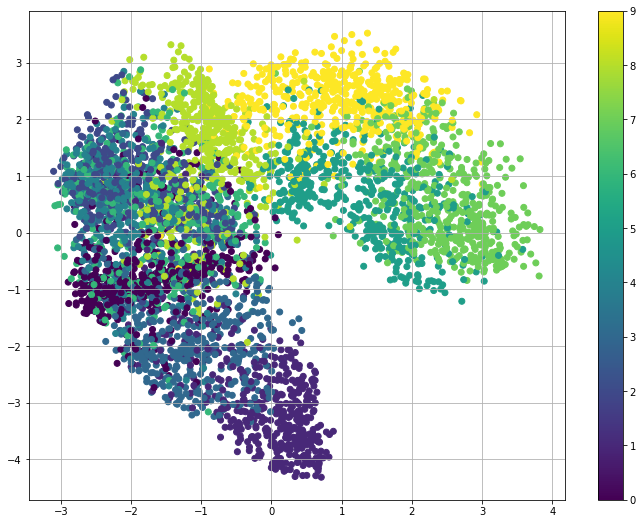

In [7]:
embed(model, n_samples=5000)

## Vector arithmetic
So how do we actually produce these smooth interpolations we speak of? From here on out, it’s simple vector arithmetic in the latent space.

<img src="https://user-images.githubusercontent.com/1387585/52692180-d8fd5d00-2f6b-11e9-8c0e-8c2af0a6e13a.png" alt="Drawing" style="width: 600px;"/>


In [8]:
def latent_space_representation(grid_w, extent, model):
    x = np.linspace(extent[0], extent[1], grid_w)
    y = x
    final_img_grid = np.zeros(shape=(28 * grid_w, 28 * grid_w))
    x_pixel, y_pixel = 0, 0
    for i in x:
        for j in y:
            z = torch.FloatTensor([i, j]).cuda()
            sample = model.decode(z).cpu()
            sample = sample.data.cpu().numpy().reshape(28, 28)
            final_img_grid[x_pixel: x_pixel + 28, y_pixel: y_pixel + 28] = sample
            y_pixel += 28
        x_pixel += 28
        y_pixel = 0
    fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
    plt.imshow(
        final_img_grid,
        extent=[extent[0], extent[1], extent[0], extent[1]],
        cmap="gray",
    )  # get current figure
    plt.title("VAE latent space representation", fontsize=14)
    plt.xlabel("z dimension 1", fontsize=14)
    plt.ylabel("z dimension 2", fontsize=14)
    plt.savefig("latent_space.png")

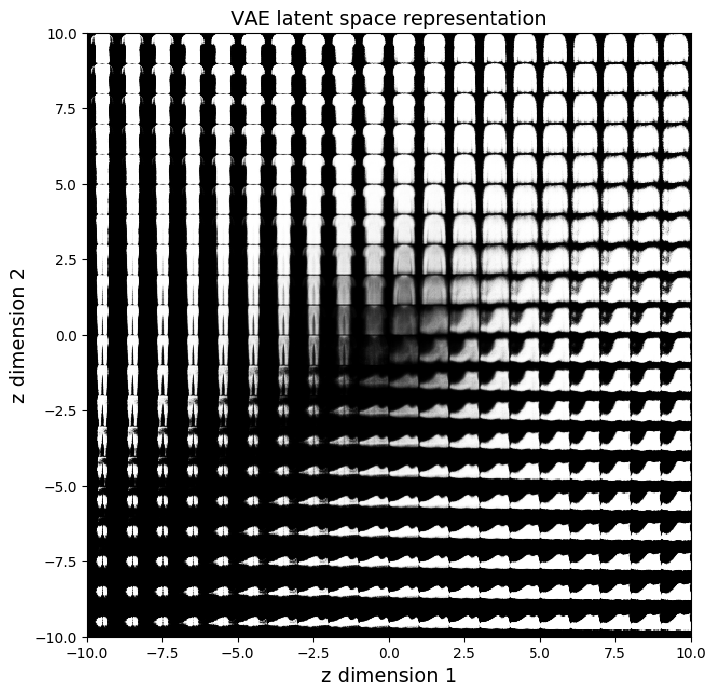

In [9]:
latent_space_representation(20, (-10, 10), model)  # explore latent space representation

## Where to from here?
There are plenty of further improvements that can be made over the variational autoencoder. You could indeed, replace the standard fully-connected dense encoder-decoder with a convolutional-deconvolutional encoder-decoder pair, such as this project[4], to produce great synthetic human face photos.

<img src="https://user-images.githubusercontent.com/1387585/52692216-fa5e4900-2f6b-11e9-83da-8a3e17ee03d3.png" alt="Drawing" style="width: 500px;"/>


You could even train an autoencoder using LSTM encoder-decoder pairs (using a modified version of the seq2seq architecture) for sequential, discrete data (something not possible with methods such as GANs), to produce synthetic text, or even interpolate between MIDI samples such as Google Brain’s Magenta’s MusicVAE[5]:

### [Click to play!]

[![IMAGE ALT TEXT HERE](https://user-images.githubusercontent.com/1387585/52692349-5628d200-2f6c-11e9-9fc0-48a272fbfe9d.png)](http://www.youtube.com/watch?v=Ir_AFDKOc-I)

VAEs work with remarkably diverse types of data, sequential or non-sequential, continuous or discrete, even labelled or completely unlabelled, making them highly powerful generative tools. I hope you now understand how VAEs work, and that you will be able to use them on your own generative endeavors as well.